1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import torchvision

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
list_path = r'C:\Users\EssenceD\Documents\Jupyter lab docs\PyTorch\Урок 5. Сегментация изображений\data_lipstick\list.csv'
mask_path = r'C:\Users\EssenceD\Documents\Jupyter lab docs\PyTorch\Урок 5. Сегментация изображений\data_lipstick\mask'
pic_path = r'C:\Users\EssenceD\Documents\Jupyter lab docs\PyTorch\Урок 5. Сегментация изображений\data_lipstick\720p'

In [4]:
files = pd.read_csv(list_path)
files

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png
...,...,...,...,...,...,...,...,...,...
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png


In [5]:
files = files.loc[files['filename'].isin(os.listdir(pic_path))]
files = files.loc[files['mask'].isin(os.listdir(mask_path))]
files.reset_index(inplace=True, drop=True)
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28539 entries, 0 to 28538
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28539 non-null  object
 1   width     28539 non-null  int64 
 2   height    28539 non-null  int64 
 3   class     28539 non-null  object
 4   xmin      28539 non-null  int64 
 5   ymin      28539 non-null  int64 
 6   xmax      28539 non-null  int64 
 7   ymax      28539 non-null  int64 
 8   mask      28539 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


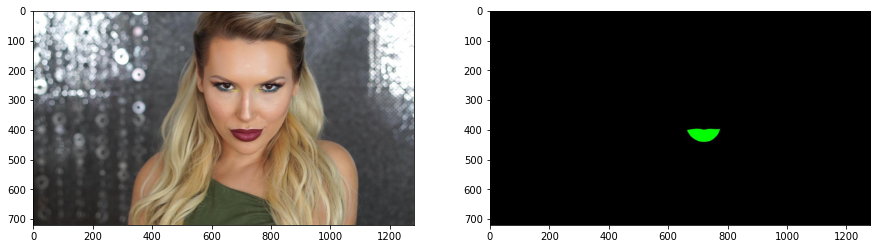

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
img_pic = plt.imread(f'{pic_path}\\{pd.Series(files["filename"])[0]}')
img_mask = plt.imread(f'{mask_path}\\{pd.Series(files["mask"])[0]}')
ax[0].imshow(img_pic)
ax[1].imshow(img_mask)
plt.show()

In [7]:
model = smp.FPN(encoder_name='resnet50',
                encoder_weights='imagenet',
                classes=1,
                activation='sigmoid'
               ).to(device=device)

preprocess_input = smp.encoders.get_preprocessing_fn('resnet50', pretrained='imagenet')

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.image_arr = self.data.iloc[:, 0]
        self.label_arr = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)
        self.preprocessing = preprocessing


    def __getitem__(self, index):
        pic = Image.open(f'{pic_path}\\{self.image_arr[index]}')
        pic = pic.resize((256, 256))
        pic = np.asarray(pic).astype('float')

        if self.preprocessing:
            pic = self.preprocessing(pic)
            pic = torch.as_tensor(pic)
        else:
            pic = torch.as_tensor(pic) / 255.0
        pic = pic.permute(2,0,1)

        mask = Image.open(f'{mask_path}\\{self.label_arr[index]}')
        mask = mask.resize((256, 256))
        mask = np.asarray(mask).astype('float')
        if self.preprocessing:
            mask = self.preprocessing(mask)
            mask = torch.as_tensor(mask)
        else:
            mask = torch.as_tensor(mask) / 255.0

        try:
            mask = mask.permute(2, 0, 1)
        except RuntimeError as err:
            print(f'{err}\nFILE: {self.label_arr[index]}')

        return pic.float(), mask.float()

    def __len__(self):
        return self.data_len

In [9]:
X_train, X_test = train_test_split(files[['filename', 'mask']], test_size=0.3, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

train_data = CustomDataset(X_train,
                           # preprocessing=preprocess_input
                           )
test_data = CustomDataset(X_test,
                          # preprocessing=preprocess_input
                          )

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])
tensor(0.0275) tensor(0.9765)
tensor(0.) tensor(1.)


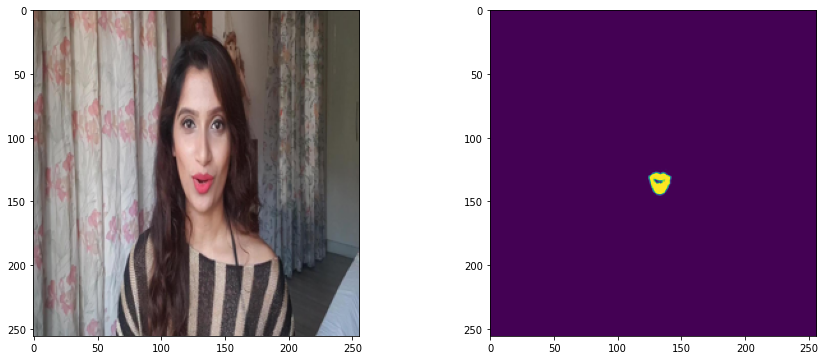

In [10]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 1])
    break

In [11]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [12]:
train_epoch = smp.utils.train.TrainEpoch(model=model,
                                         loss=criterion,
                                         metrics=metrics,
                                         optimizer=optimizer,
                                         device=device,
                                         verbose=True)

valid_epoch = smp.utils.train.ValidEpoch(model=model,
                                         loss=criterion,
                                         metrics=metrics,
                                         device=device,
                                         verbose=True)

In [13]:
max_score = 0.0

for i in range(5):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, r'C:\Users\EssenceD\Documents\Jupyter lab docs\PyTorch\Урок 5. Сегментация изображений\best_model.pth')
        print('Model saved!')    

Epoch: 1
valid: 100%|███████| 857/857 [05:38<00:00,  2.54it/s, dice_loss - 0.07508, iou_score - 0.8649]
Model saved!
Epoch: 2
valid: 100%|████████| 857/857 [04:56<00:00,  2.89it/s, dice_loss - 0.06357, iou_score - 0.884]
Model saved!
Epoch: 3
valid: 100%|███████| 857/857 [04:58<00:00,  2.87it/s, dice_loss - 0.05955, iou_score - 0.8908]
Model saved!
Epoch: 4
valid: 100%|█████████| 857/857 [05:11<00:00,  2.75it/s, dice_loss - 0.056, iou_score - 0.8964]
Model saved!
Epoch: 5
valid: 100%|███████| 857/857 [05:40<00:00,  2.52it/s, dice_loss - 0.05423, iou_score - 0.8993]
Model saved!


In [16]:
net = torch.load('./best_model.pth')

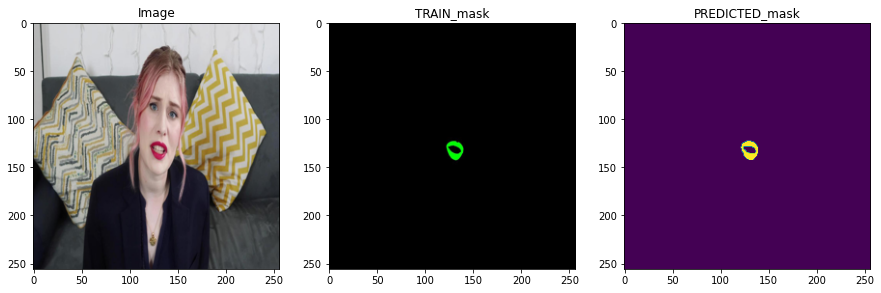

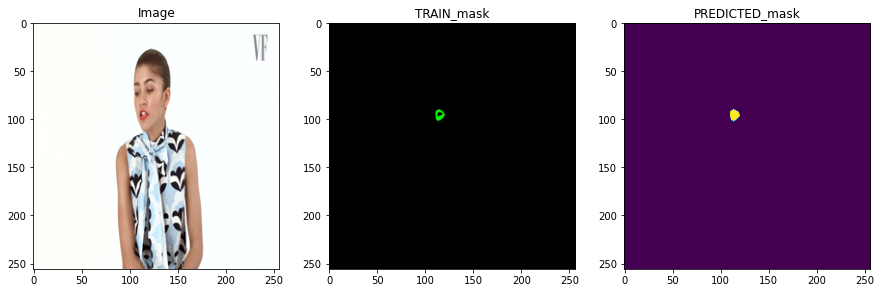

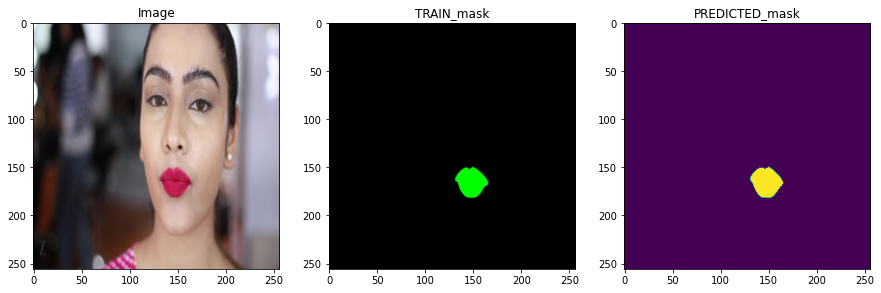

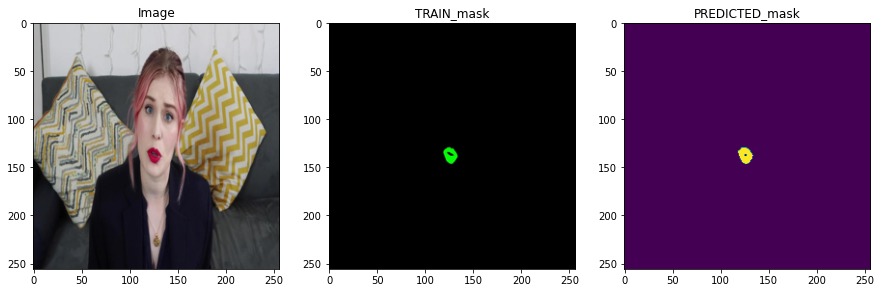

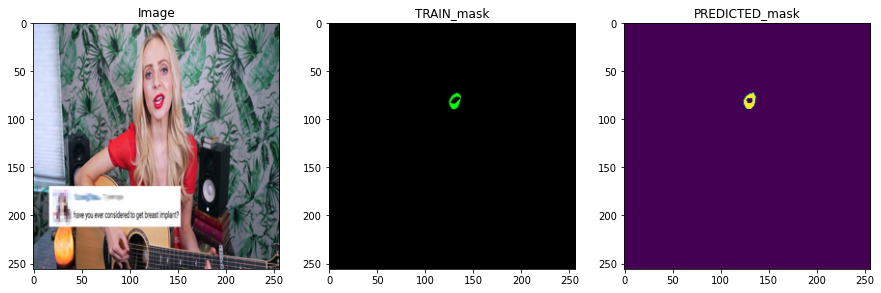

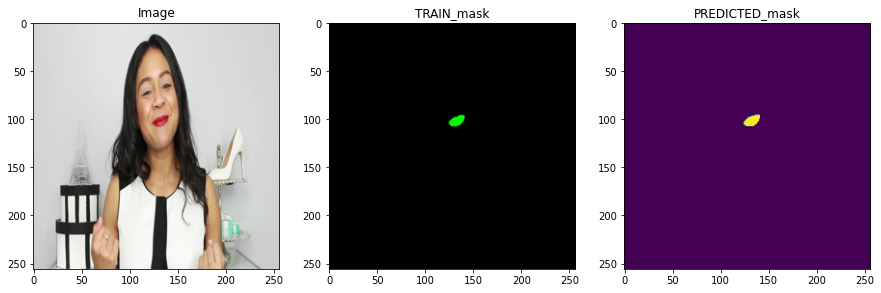

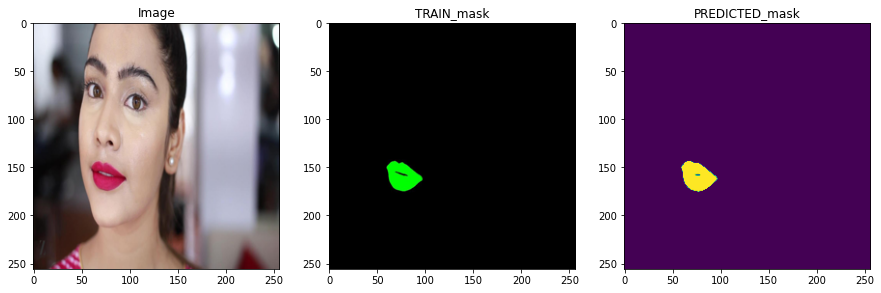

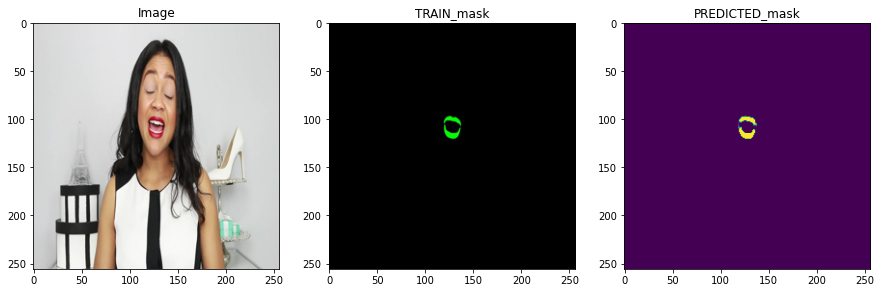

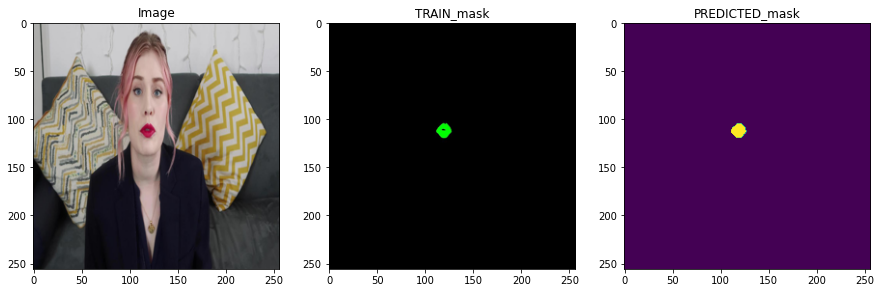

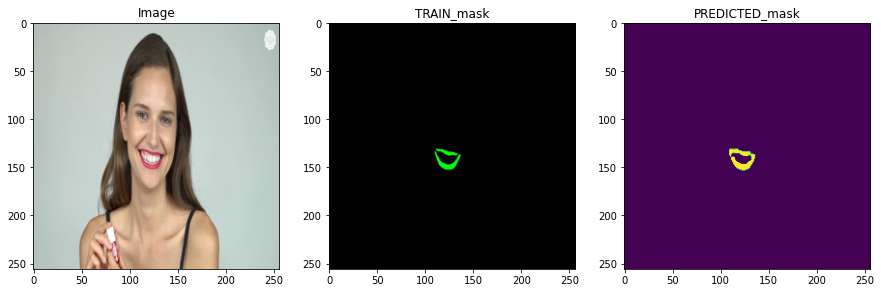

In [31]:
for image, mask in test_data_loader:
    for i in range(image.shape[0]):
        pred = net(image[i][None].to(device))[0, ...].detach().cpu()
        fig, ax = plt.subplots(1, 3, figsize=(15, 7))
        
        ax[0].imshow(image[i].permute(1, 2, 0))
        ax[0].set_title('Image')
        
        ax[1].imshow(mask[i].permute(1, 2, 0))
        ax[1].set_title('TRAIN_mask')
        
        ax[2].imshow(pred.permute(1, 2, 0))
        ax[2].set_title('PREDICTED_mask')
        plt.show()
    break